In [102]:
import torch
import torchvision
from torchvision import transforms
import numpy
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import numpy as np
import pickle as pkl

In [103]:
def plot_results(fldr):
    dp_info = pkl.load(open(fldr + "dp_stats.pkl", 'rb'))
    head_info = pkl.load(open(fldr + "head_stats.pkl", 'rb'))
    task_dp_stats = pkl.load(open(fldr + "dp_stats.pkl", 'rb'))

    fig, ax = plt.subplots(1, 3, figsize=(22, 6))
    kl_stats = np.array(head_info['kl_stats'])
    kl_stats = np.reshape(kl_stats, (-1, 29))
    kl_stats = kl_stats.mean(axis=-1)
    stats = kl_stats.max(), kl_stats.min()

    ax[0].plot(kl_stats, label='KL-Stats. Max = {:.3f} | Min = {:.3f}'.format(*stats))
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('KL-DIV')
    ax[0].legend()

    l2_stats = np.array(head_info['l2_stats.0']) if 'l2_stats.0' in head_info else np.array(head_info['l2_stats'])
    if l2_stats[0] > 1.0:
        l2_stats = np.sqrt((l2_stats**2) / (256 * 6))
    l2_stats = np.reshape(l2_stats, (-1, 29))
    l2_stats = l2_stats.mean(axis=-1)
    stats = l2_stats.max(), l2_stats.min()
    ax[1].plot(l2_stats, label='L2-Stats. Max = {:.3f} | Min = {:3f}'.format(*stats))
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Mean Per Parameter L2-Distance')
    ax[1].legend()

    for k, v in task_dp_stats.items():
        v = np.array(v)
        v = np.reshape(v, (-1, 29))
        v = v.mean(axis=-1)
        stats = v.max(), v.min()
        ax[2].plot(v, label='{}. Max = {:.3f} | Min = {:3f}'.format(k, *stats))
        ax[2].set_xlabel('Iteration')
        ax[2].set_ylabel('Dot-Product With Dev-Gradient')
        ax[2].legend()
    ax[2].plot([0]*len(v))
    plt.tight_layout()
    
    dps = head_info['dp_stats']
    head_dps = np.stack(dps[0::2])
    bias_dps = np.reshape(np.stack(dps[1::2]), (-1, 1))
    dps = np.concatenate((head_dps, bias_dps), axis=-1)
    dps = np.reshape(dps, (100, -1, 6))
    dps = dps.mean(axis=1)
    ids = ["head-{}".format(idx) for idx in range(dps.shape[-1] - 1)]
    ids.append("bias")
    fig, ax = plt.subplots(1, dps.shape[-1], figsize=(22, 6))
    for idx in range(dps.shape[-1]):
        ax[idx].plot(dps[:, idx], label=ids[idx])
        ax[idx].plot([0.5]*dps.shape[0])
        ax[idx].set_xlabel('Iteration')
        ax[idx].set_ylabel('Cosine Similarity')
        ax[idx].legend()
    plt.tight_layout()
    plt.legend()

In [104]:
def tsne(fldr):
    from sklearn.manifold import TSNE
    import pdb
    tsne_info = pkl.load(open(fldr + "head_dicts_tsne.pkl", 'rb'))
    X, names = [], []
    for dict_ in tsne_info:
        for k, v in dict_.items():
            if 'bias' in k:
                continue
            k = 'corrupt' if 'corrupt' in k else 'main'
            names.extend(["{}-{}".format(k, i) for i in range(len(v)) ])
            X.extend([j for j in v ])
    X = np.array(X)
    X_embedded = TSNE(n_components=2).fit_transform(X)
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(X_embedded[:, 0], X_embedded[:, 1])
    colors = ['tab:red', 'tab:green', 'tab:cyan', 'tab:blue', 'tab:orange']*2
    for i, txt in enumerate(names):
        ax.annotate(txt, (X_embedded[i, 0], X_embedded[i, 1]), color=colors[i])
    plt.show()
    
def pca(fldr):
    from sklearn.decomposition import PCA
    import pdb
    tsne_info = pkl.load(open(fldr + "head_dicts_tsne.pkl", 'rb'))
    X, names = [], []
    for dict_ in tsne_info:
        for k, v in dict_.items():
            if 'bias' in k:
                continue
            k = 'corrupt' if 'corrupt' in k else 'main'
            names.extend(["{}-{}".format(k, i) for i in range(len(v)) ])
            X.extend([j for j in v ])
    X = np.array(X)
    dp_metric = lambda x, y :(x * y).sum() / (np.linalg.norm(x)* np.linalg.norm(y))
    X_embedded = PCA(n_components=2, whiten=True).fit_transform(X)
    print(X_embedded.shape, X.shape)
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(X_embedded[:, 0], X_embedded[:, 1])
    colors = ['tab:red', 'tab:green', 'tab:cyan', 'tab:blue', 'tab:orange']*2
    for i, txt in enumerate(names):
        ax.annotate(txt, (X_embedded[i, 0], X_embedded[i, 1]), color=colors[i])
    plt.show()

(10, 2) (10, 256)


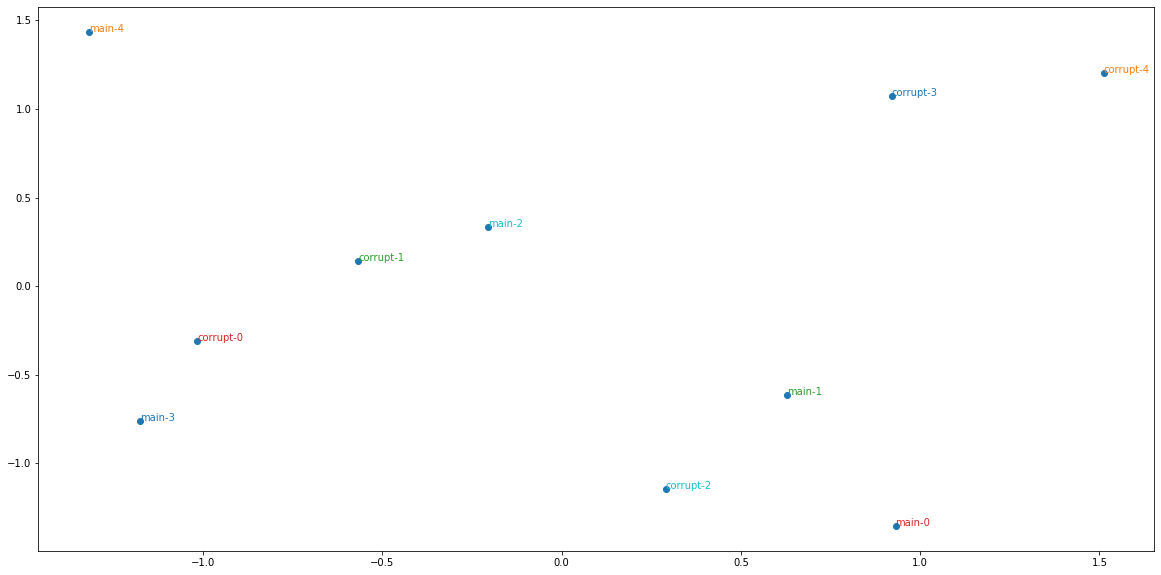

In [105]:
fldr = "m4m_cache/dp_tests/main_head_is_dp.gather_stats.nogradclip.tsne/meta_medium-sized_mammals/0/"
# tsne(fldr)
pca(fldr)

# Notes #
1. Full Dataset is used
2. No Dropout
3. SGD

First Row = **KL Divergence over Time, Per-parameter L2 Distance, Dot-Products with meta-gradient** <br>
Second Row = **Cosine Similarity between corresponding rows of weight matrix in classification layers of medium-sized_mammals and corrupted-medium-sized_mammals**

## Summary ##

1. KL divergence falls close to 0 for all models compared.<br>
2. L2 distance does not fall significantly <br>
**Inference** - Distances in parameter space do not tell us much about distances in function space in this setting <br>
3. The effect of mismatched dot-products is more pronounced under small learning rate as compared to large learning rate. NB - orginal graphs I showed were all low-learning rate graphs because that was the regime we were exploring.<br> 
4. In all solutions, both the corrupted and main heads show high degrees of cosine similarity in terms of the prototypes for each class. However, the similarity is much higher in the case of a large learning rate <br>
**Inference** - The types of solutions found using a small learning rate under different heads are more different from each other. There's a higher degree of agreement on solution heads in the large learning rate setting

# Low Learning Rate #

## Low Learning Rate = 5e-3 | Medium-sized_mammals is dev head ##

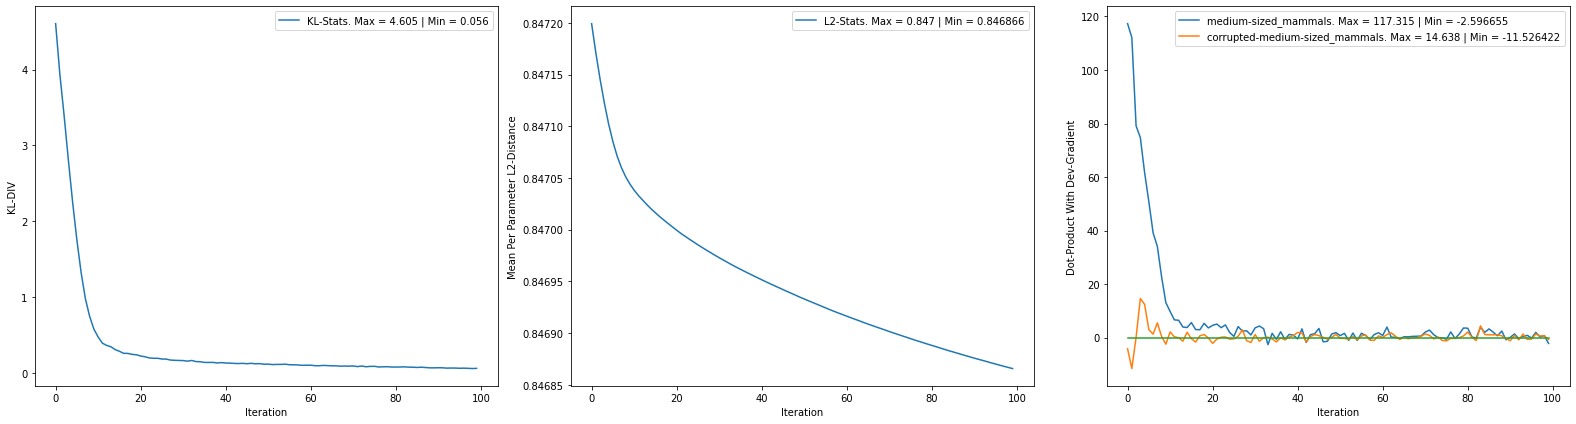

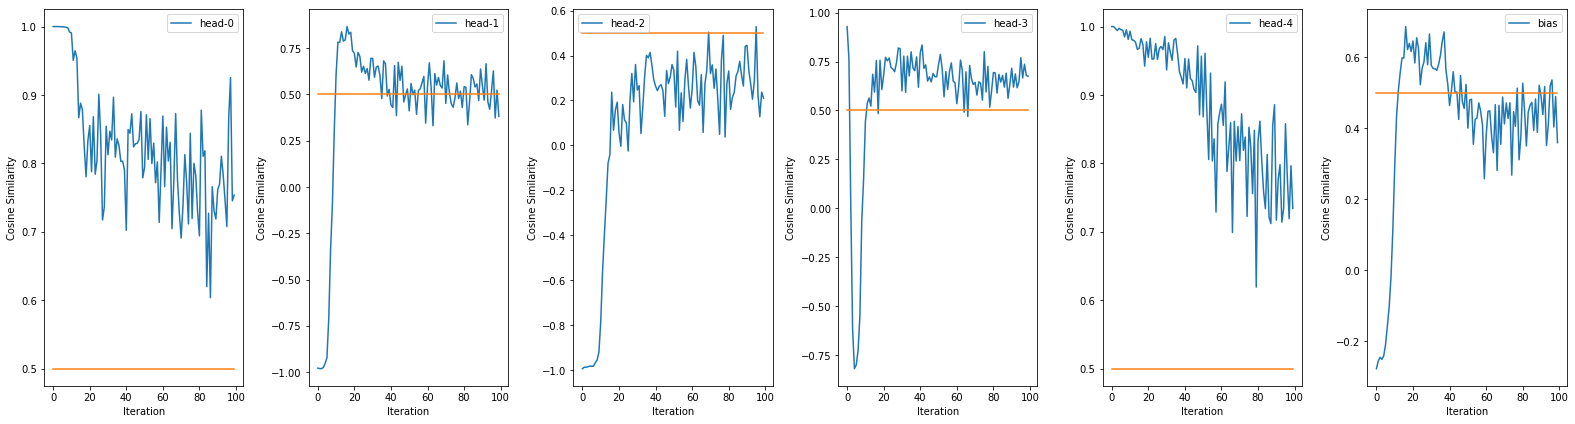

In [52]:
fldr = "m4m_cache/dp_tests/main_head_is_dp.gather_stats/meta_medium-sized_mammals/0/"
plot_results(fldr)

## Low Learning Rate = 5e-3 | Corrupted-medium-sized_mammals is dev head ##

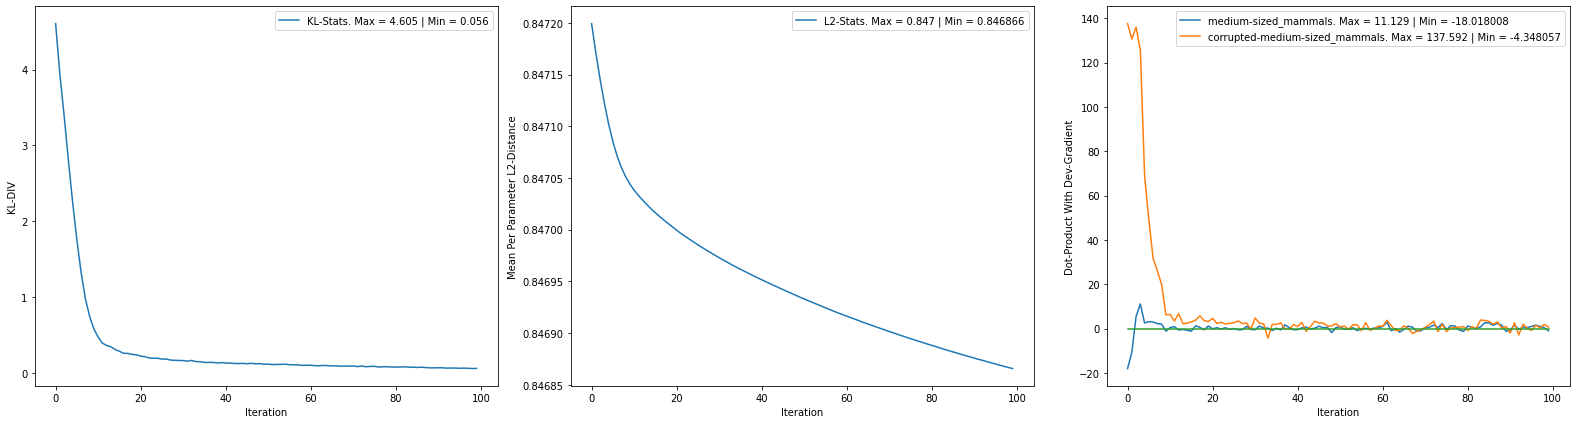

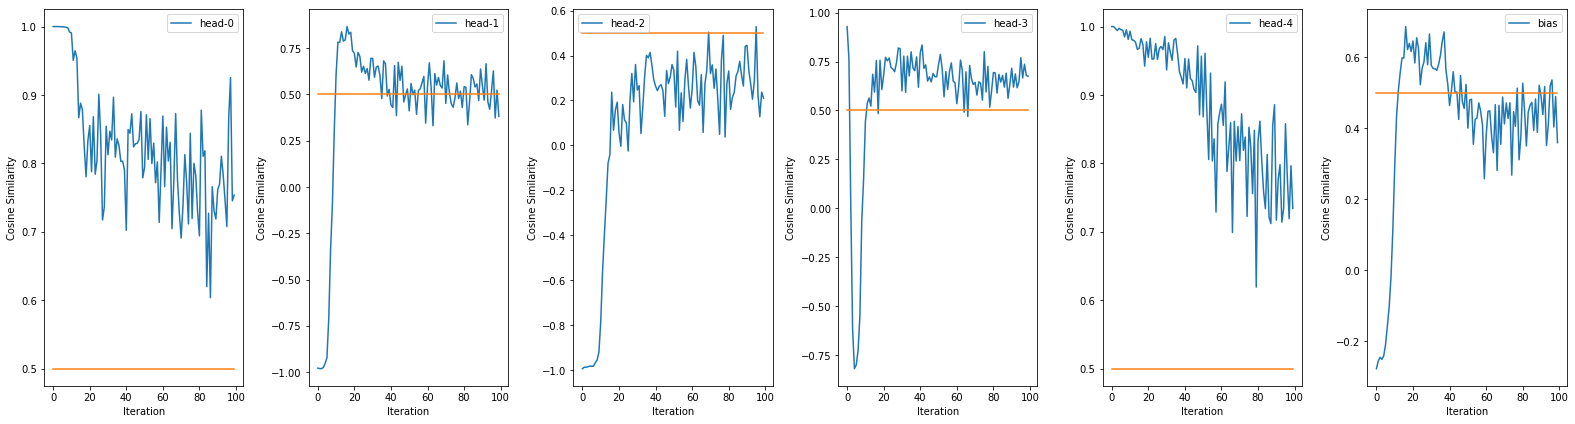

In [53]:
fldr = "m4m_cache/dp_tests/corrupted_head_is_dp.gather_stats/meta_medium-sized_mammals/0/"
plot_results(fldr)

## Low Learning Rate = 5e-3 | Medium-sized_mammals is dev head | No Gradient Clipping before model update ##
I removed gradient clipping here so as to see if it was accountable for the per-parameter l2 distance not changing much. Still similar results

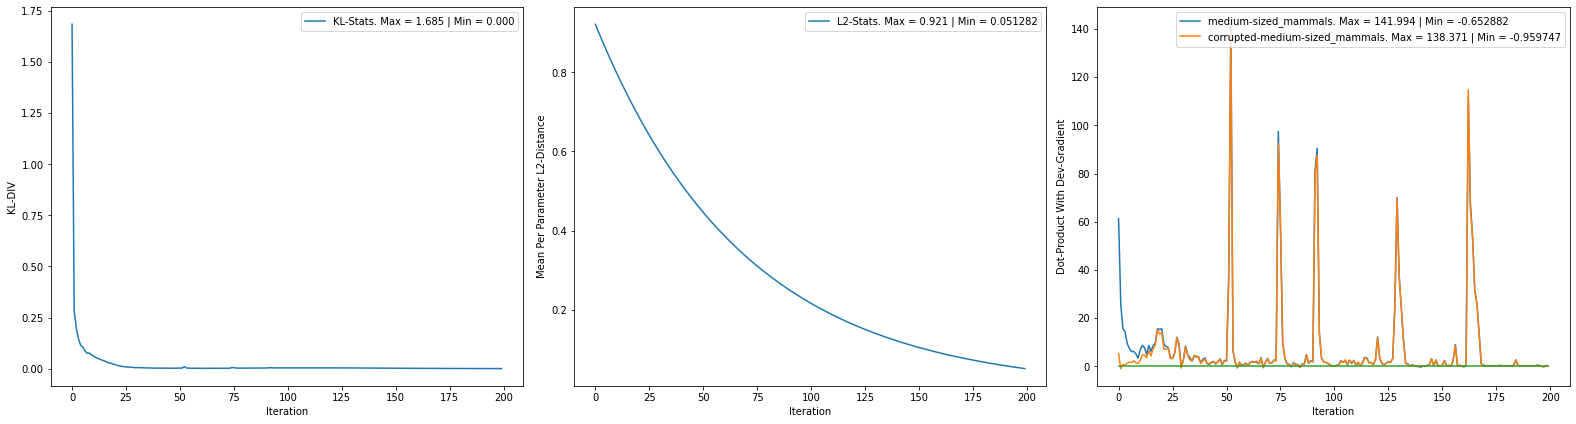

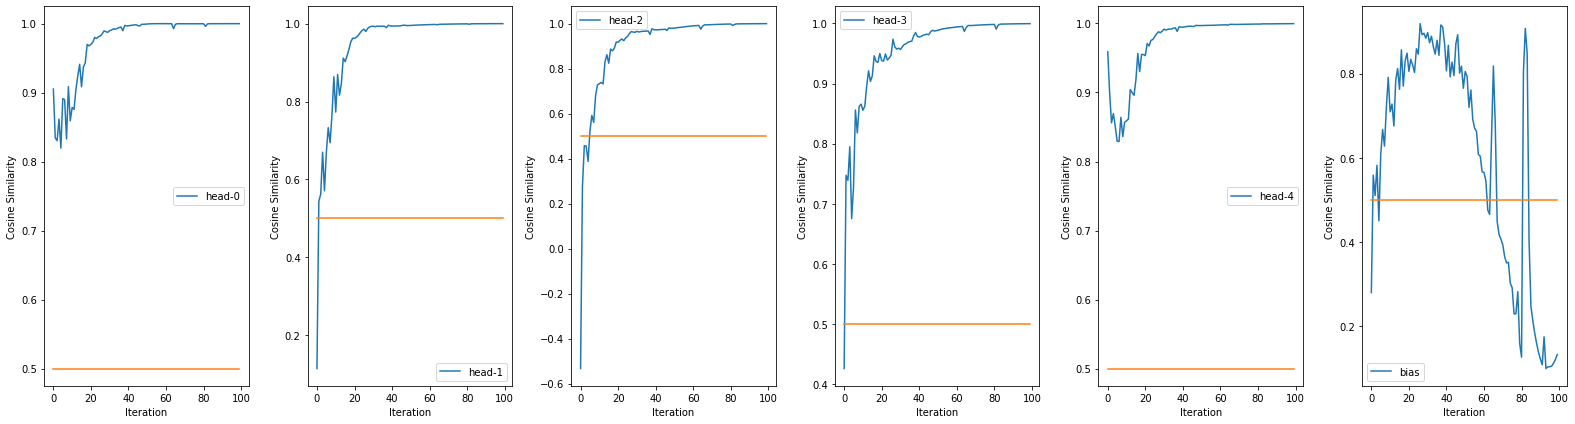

In [ ]:
fldr = "m4m_cache/dp_tests/main_head_is_dp.gather_stats.nogradclip.tsne/meta_medium-sized_mammals/0/"
plot_results(fldr)
tsne(fldr)

# Medium Learning Rate #

## Medium Learning Rate = 1e-1 | Medium-sized_mammals is dev head ##

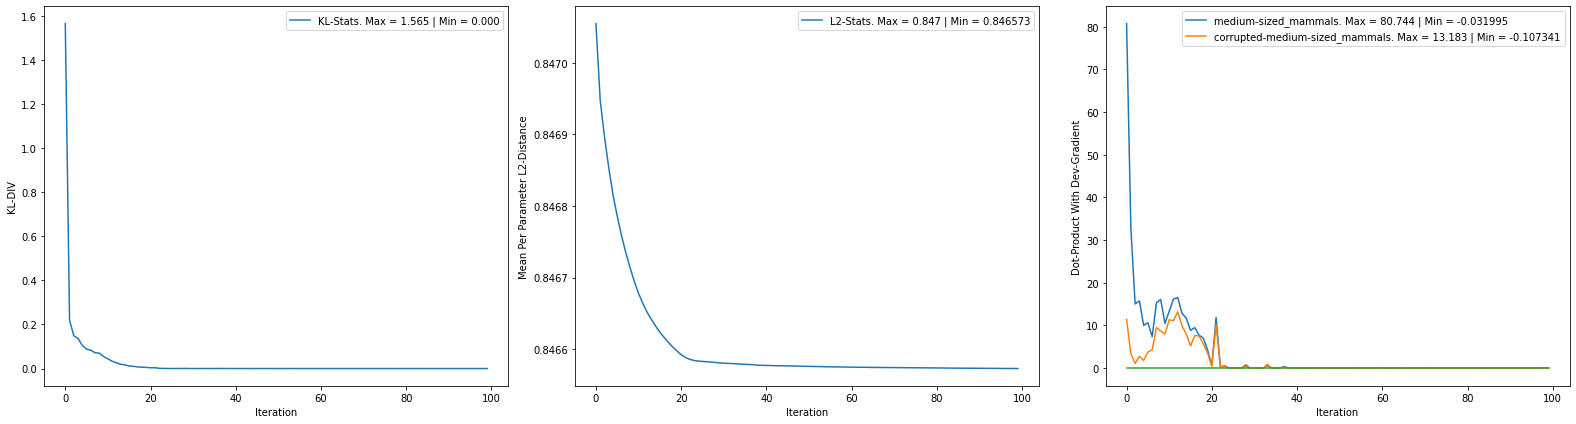

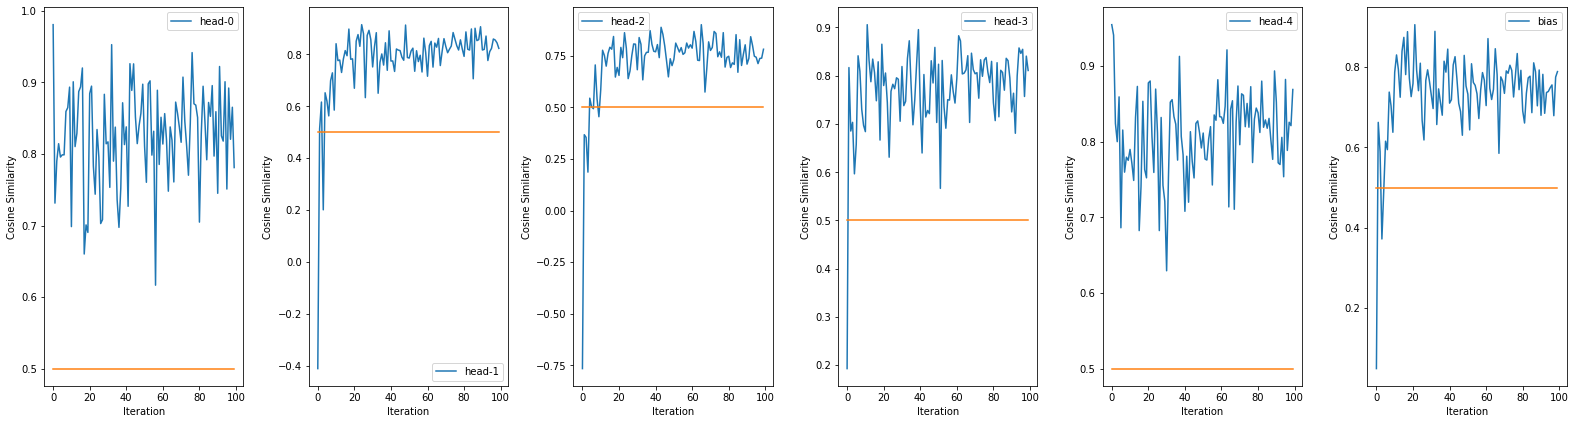

In [55]:
fldr = "m4m_cache/dp_tests/main_head_is_dp.gather_stats.largerlr/meta_medium-sized_mammals/0/"
plot_results(fldr)

## Medium Learning Rate = 1e-1 | Corrupted-medium-sized_mammals is dev head ##

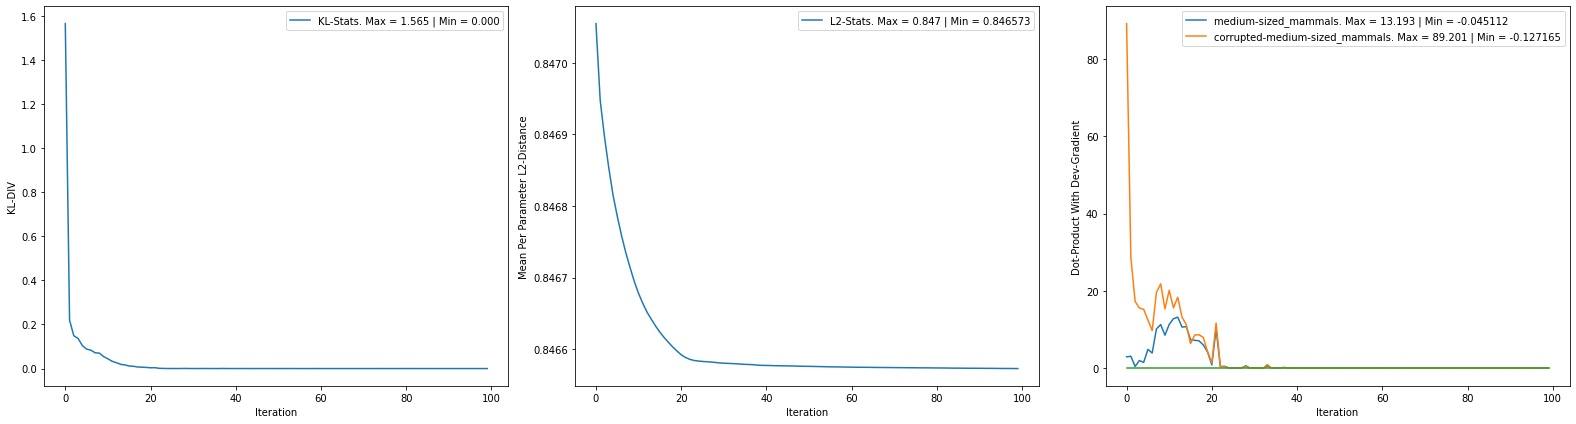

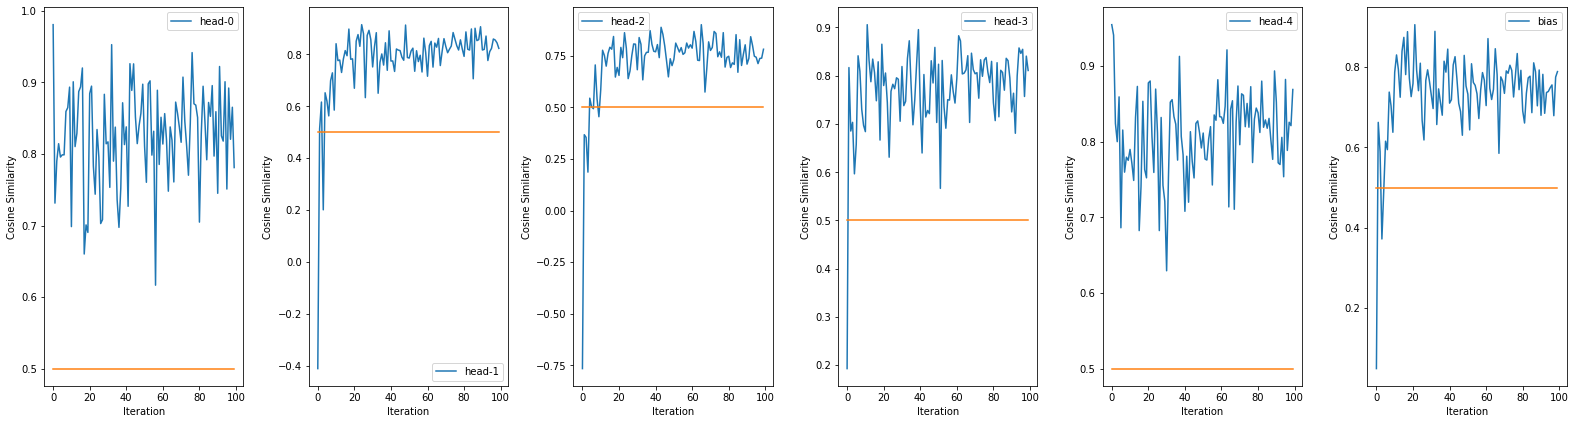

In [56]:
fldr = "m4m_cache/dp_tests/corrupted_head_is_dp.gather_stats.largerlr/meta_medium-sized_mammals/0/"
plot_results(fldr)

# Large LR = 1.0 + No Gradient Clippping #
* L2 distance falls more significantly as compared to other runs

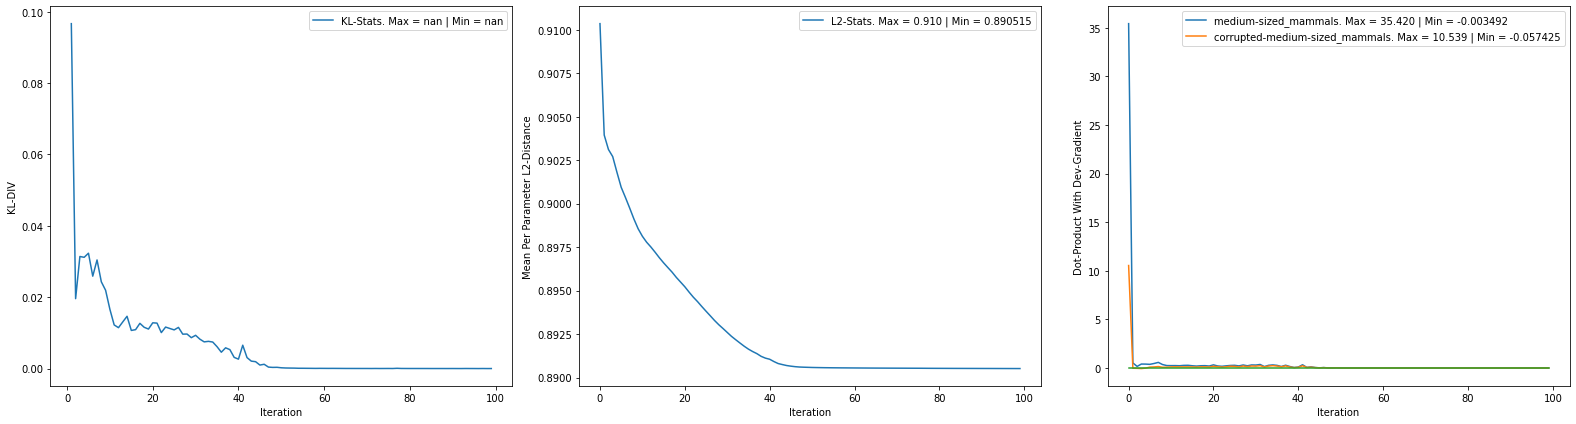

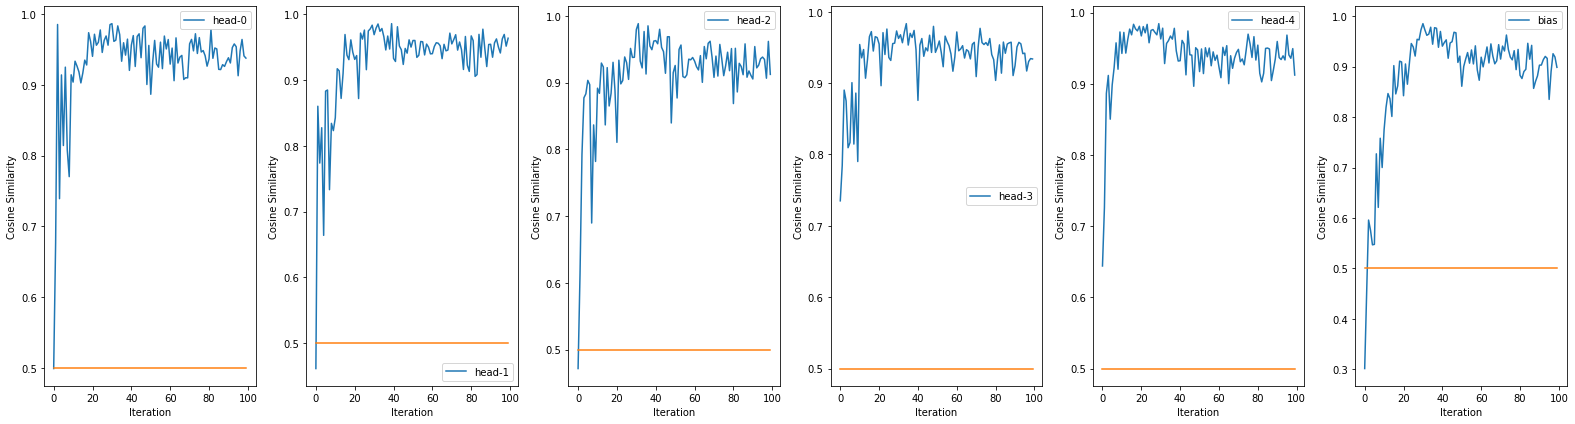

In [58]:
fldr = "m4m_cache/dp_tests/main_head_is_dp.gather_stats.largestlr.nogradclip/meta_medium-sized_mammals/0/"
plot_results(fldr)

In [59]:
############################## IGNORE ############################################################ 

In [2]:
tform = torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor(),
                    ])
train = torchvision.datasets.CIFAR100('~/', train=True, transform=tform)

In [3]:
examples = []
num_egs = 10
for pair in train:
    examples.append(pair[0])
    if len(examples) > num_egs:
        break
xs = torch.stack(examples)
print(xs.shape)

torch.Size([11, 3, 32, 32])


In [ ]:
after_horzflip = torchvision.transforms.RandomHorizontalFlip(p=1.0)(xs)

In [8]:
rotations = [0, 90, 180, 270]
chosen_rots = np.random.choice(rotations, size=len(xs))
results = []
to_pil_tform = transforms.ToPILImage()
for idx, rot in enumerate(chosen_rots):
    this_xs = xs[idx]
    pil_img = to_pil_tform(this_xs).convert("RGB")
    pil_img = TF.rotate(pil_img, rot)
    new_xs = TF.pil_to_tensor(pil_img)
    results.append(new_xs.float() / 255.0)
afters = torch.stack(results)
print(results[0].mean().item(), xs[0].mean().item())


0.5423381924629211 0.5423381924629211


In [69]:
resized_crop = torchvision.transforms.RandomResizedCrop((32, 32), scale=(0.5, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2)
results = []
to_pil_tform = transforms.ToPILImage()
for idx, rot in enumerate(chosen_rots):
    this_xs = xs[idx]
    pil_img = to_pil_tform(this_xs).convert("RGB")
    pil_img = resized_crop(pil_img)
    new_xs = TF.pil_to_tensor(pil_img)
    results.append(new_xs)
afters = torch.stack(results)

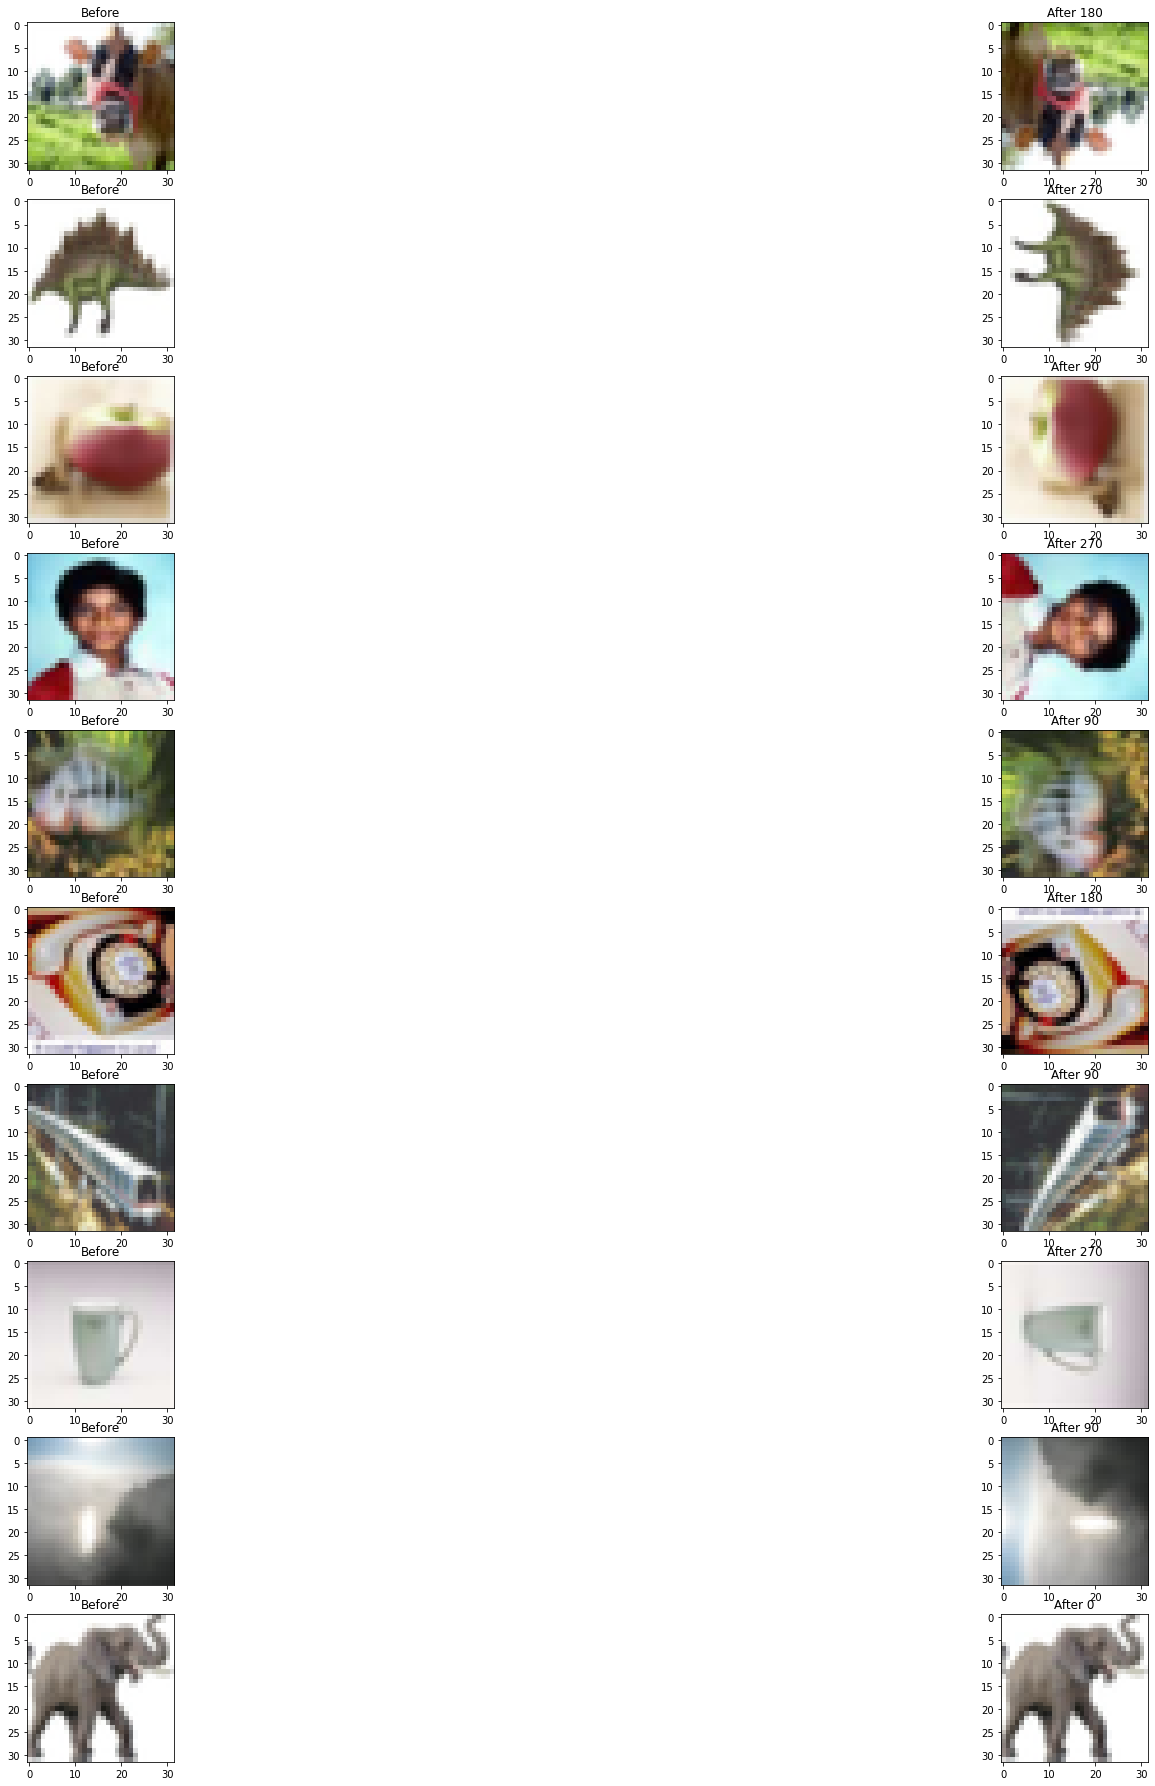

In [75]:
fig, axes = plt.subplots(10, 2, figsize=(32, 32))
for i in range(10):
    before = xs[i]
    after = afters[i]
    axes[i][0].set_title('Before')
    axes[i][0].imshow(before.permute(1, 2, 0))
    axes[i][1].set_title('After {}'.format(chosen_rots[i]))
    axes[i][1].imshow(after.permute(1, 2, 0))